In [1]:
import pandas as pd
import numpy as np

In [340]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6532 non-null   object 
 2   Customer_care_calls  5346 non-null   float64
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 538.8+ KB


In [341]:
# train['Weight_in_gms'] = train[train['Weight_in_gms'].notnull()]['Weight_in_gms'].astype(int)
# train.corr()

In [342]:
# Mode_of_Shipment의 결측값은 Warehouse_block, Product_importance, Weight_in_gms와 연관이 있지 않을까?
# 하지만 Weight_in_gms는 결측값이 있어서 참고해서 채우기 어려울듯하다.
# 따라서 Warehouse_block, Product_importance를 groupby해서 본 결과 ship이 대부분이라 ship으로 일단 채워보려 한다.
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  5346 non-null   float64
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 538.8+ KB


In [343]:
train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).mean()

Customer_care_calls
Customer_rating Mode_of_Shipment                     
1                Flight                      4.160256
                 Road                        4.005435
                 Ship                        3.990028
2                Flight                      4.335366
                 Road                        4.107595
                 Ship                        3.997396
3                Flight                      4.166667
                 Road                        4.136095
                 Ship                        4.041931
4                Flight                      4.054545
                 Road                        4.012821
                 Ship                        4.019152
5                Flight                      3.953333
                 Road                        4.208589
                 Ship                        4.096336

In [344]:
train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])

Customer_care_calls
Customer_rating Mode_of_Shipment                     
1                Flight                           4.0
                 Road                             3.0
                 Ship                             3.0
2                Flight                           5.0
                 Road                             4.0
                 Ship                             4.0
3                Flight                           4.0
                 Road                             4.0
                 Ship                             4.0
4                Flight                           3.0
                 Road                             4.0
                 Ship                             4.0
5                Flight                           3.0
                 Road                             4.0
                 Ship                             4.0

In [345]:
# 결측치를 채우기 전 가설
# Customer_care_calls는 배송조회 문의전화 건수로 Customer_rating, Mode_of_Shipment가 관련 있다고 가정
# 생각보다 Customer_care_calls의 범주가 2-7사이로 다양하지 않음. 평균일 경우 모두 4 최빈값일 경우는 3,4,5가 나타난다.
# 따라서 하나라도 다른 최빈값이 데이터의 특성을 더 반영하고 있다고 추측하여 최빈값으로 채우기로 함
def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 538.8+ KB


(array([1299.,  776.,  326.,  343.,  903., 1265., 1193.,  345.,    0.,
           3.]),
 array([1001. , 1685.5, 2370. , 3054.5, 3739. , 4423.5, 5108. , 5792.5,
        6477. , 7161.5, 7846. ]),
 <BarContainer object of 10 artists>)

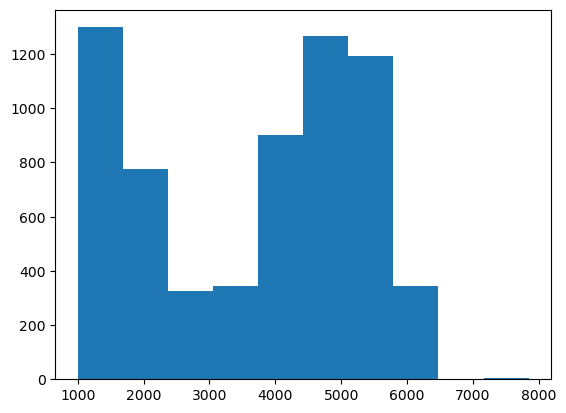

In [346]:
import matplotlib.pyplot as plt
plt.hist(train[train['Weight_in_gms'].notnull()]['Weight_in_gms'])

In [347]:
## gms 경우는 평균이 히스토그램에 따르면 데이터의 성질을 잘 반영하지 못한다고 생각하여 median으로 시도했으나
# accuracy기준으로 mean의 성능이 더높게 나오는듯하여 mean으로 교체
def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
train['Weight_in_gms'] = train.apply(fill_gms, axis = 1).astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [348]:
train['Prior_purchases'].value_counts()
train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


### Customer_rating에는 이상치 99가 있다 -> Customer_care_calls 몇 이상? 인 사람들의 평균 Customer_rating로 바꾸면 되지 않을까?
### 결측치도 있지만 ?인 컬럼도 존재한다
###  Discount_offered 는 결측치가 너무 많아서 사용할 수 없을듯하다.
### Gender는 중요도가 그다지 높아보이지 않는다.
### customer_care_calls 는 도착여부와 관련이 있는듯함.  -> 전화를 많이해서 도착을 한것일까, 도착을 많이 안해서 전화를 많이 한것인가?
### prior_purchases는 겉으로는 중요해보이지 않지만 회사 내부에서 vip 고객일수록 배송을 우선시한다는 가정을 해본다면 prior_purchases구간화를 진행하고 도착여부에 따른 groupby를 진행해서 채울 수 있지 않을까?
### Mode_of_shipment는 Weight_in_gms와 warehouse_block 

## 전처리 관련
- 1. 결측치 null 대신 ?로 표시되어 있는 데이터들을 nan으로 변경
- 2. Discount_offered는 결측치가 너무 많아 사용하기 힘들듯하다
- 3. Mode_of_Shipment, Product_importance에 가벼운 오타를 수정필요
- 4. 결측치 채우는 순서는 결측치가 적은 컬럼부터 채우는것이 맞지 않을까? (결측치 컬럼을 채울 때 결측치가 있는 컬럼을 참고할 수는 없기 때문?, 만약 결측치가 없는 컬럼을 보고 채운다면 얘기가 다름)
- 5. 위의 4번대로라면 결측치 채울 순서는 Product_importance, Mode_of_Shipment, Weight_in_gms, Prior_purchases, Customer_care_calls
- 6. 범주형 변수와 연속형 변수가 섞여있기 때문에 변수 타입이 섞여있을 때의 상관관계를 볼 수 있을지 알아봐야할듯 (Point biserial correlation라는 것이 있다하는데 scipy.stats라이브러리 알아봐야할듯)

- customer_care_calls 는 도착여부와 관련이 있는듯함.  -> 전화를 많이해서 도착을 한것일까, 도착을 많이 안해서 전화를 많이 한것인가?
- prior_purchases는 겉으로는 중요해보이지 않지만 회사 내부에서 vip 고객일수록 배송을 우선시한다는 가정을 해본다면 prior_purchases구간화를 진행하고 도착여부에 따른 groupby를 진행해서 채울 수 있지 않을까?

In [338]:
train['Reached.on.Time_Y.N'].value_counts()

1    4101
0    2796
Name: Reached.on.Time_Y.N, dtype: int64

In [357]:
#!pip install catboost
#!pip install xgboost

     --------------------------------------- 70.9/70.9 MB 18.2 MB/s eta 0:00:00


In [302]:
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import  CatBoostClassifier
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import OneSidedSelection, TomekLinks
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [342]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [344]:
train.columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N'],
      dtype='object')

In [145]:
from sklearn.preprocessing import LabelEncoder
object_columns = train.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(train[i])
    train[i] = lb.transform(train[i])
    
    print(f'category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')

category : [0 1 2 3 4]
classes : ['A' 'B' 'C' 'D' 'F']

category : [0 1 2]
classes : [' Flight' ' Road' ' Ship']

category : [0 1 2]
classes : ['high' 'low' 'medium']



In [349]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

## Ada

In [337]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
ab = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.97, n_estimators=2, random_state=42)
ab.fit(x_train_ss, y_train)
pred = ab.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6603864734299517
0.6811791383219955


array([[616, 216],
       [487, 751]], dtype=int64)

In [307]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

ab = AdaBoostClassifier(random_state=42)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

param_grid = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}
from sklearn.model_selection import GridSearchCV
ab_grid = GridSearchCV(ab, param_grid, scoring='accuracy')
ab_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {ab_grid.best_score_}')
print('best param : ', ab_grid.best_params_)
pred = ab_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best accuracy : 0.667700790611356
best param :  {'algorithm': 'SAMME', 'learning_rate': 0.97, 'n_estimators': 2}


array([[616, 216],
       [487, 751]], dtype=int64)

## gbm

In [350]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(x_train_ss, y_train)
pred = gb.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6700483091787439
0.6848177203507153


array([[645, 187],
       [496, 742]], dtype=int64)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

gb = GradientBoostingClassifier(random_state=42)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

param_grid = {'n_estimators': [50, 100, 500],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
              'subsample':[0.5, 0.7, 1.0],
              'max_depth':[4, 7, 10]
             }
from sklearn.model_selection import GridSearchCV
gb_grid = GridSearchCV(gb, param_grid, scoring='accuracy')
gb_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {gb_grid.best_score_}')
print('best param : ', gb_grid.best_params_)
pred = gb_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

## SVC

In [ ]:
from sklearn.preprocessing import LabelEncoder
object_columns = train.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(train[i])
    train[i] = lb.transform(train[i])
    
    print(f'category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')

In [200]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

input

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Weight_in_gms
0,2,2,2,2,135,3.0,1,1339
1,4,0,5,3,225,5.0,1,1082
2,4,2,3,1,229,3.0,1,4971
3,4,2,3,2,228,3.0,2,5640
4,3,0,4,1,195,6.0,0,4944
...,...,...,...,...,...,...,...,...
6994,3,2,4,2,232,5.0,2,1783
6995,4,2,3,5,228,2.0,2,5208
6996,3,2,3,1,300,5.0,1,1787
6997,0,1,3,1,232,2.0,2,4719


In [232]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6415458937198067
0.7180851063829787


array([[383, 449],
       [293, 945]], dtype=int64)

In [228]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(C=0.1, gamma=10, random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.5971014492753624
0.7435424354243543


In [229]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[  27,  805],
       [  29, 1209]], dtype=int64)

In [351]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(C=100, gamma=0.01, random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6352657004830918
0.7024044146629878


In [231]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[441, 391],
       [357, 881]], dtype=int64)

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }
from sklearn.model_selection import GridSearchCV
svc_grid = GridSearchCV(SVC, param_grid, scoring='accuracy')
svc_grid.fit(x_train_ss, y_train)
print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)

In [222]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }
from sklearn.model_selection import GridSearchCV
svc_grid = GridSearchCV(svc, param_grid, scoring='accuracy')
svc_grid.fit(x_train_ss, y_train)
print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)

best f1 : 0.6434628133749557
best param :  {'C': 100, 'gamma': 0.01}


## mlp

In [236]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=1, max_iter=1000)
mp.fit(x_train_ss, y_train)
# param_grid={'hidden_layer_sizes': [10, 30, 50, 100], 'solver': ['sgd', 'adam'], 
#              'activation': ['tanh', 'relu']}
# from sklearn.model_selection import GridSearchCV
# mp_grid = grid_search=GridSearchCV(mp, param_grid, scoring='f1')
# mp_grid.fit(x_train_ss, y_train)
# print(f'best f1 : {mp_grid.best_score_}')
# print('best param : ', mp_grid.best_params_)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6256038647342995
0.7339512530037762


array([[ 226,  606],
       [ 169, 1069]], dtype=int64)

In [237]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=1, max_iter=1000)
param_grid={'hidden_layer_sizes': [50, 100], 'solver': ['adam'], 
             'activation': ['tanh', 'relu'], 'alpha': ([0.01,0.001, 0.0001]),   'learning_rate_init': [0.01, 0.001]}
from sklearn.model_selection import GridSearchCV
mp_grid = GridSearchCV(mp, param_grid, scoring='accuracy')
mp_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {mp_grid.best_score_}')
print('best param : ', mp_grid.best_params_)
pred = mp_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best accuracy : 0.6627249809588174
best param :  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01, 'solver': 'adam'}


array([[637, 195],
       [503, 735]], dtype=int64)

In [352]:
## mean
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', 
                   alpha=0.0001, max_iter=1000, learning_rate_init=0.01, random_state=42)
mp.fit(x_train_ss, y_train)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6483091787439613
0.6767317939609236


array([[580, 252],
       [476, 762]], dtype=int64)

In [286]:
## median
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', 
                   alpha=0.0001, max_iter=1000, learning_rate_init=0.01, random_state=42)
mp.fit(x_train_ss, y_train)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6483091787439613
0.6767317939609236


array([[580, 252],
       [476, 762]], dtype=int64)

### 일단 svm 모델이 가장 높아보이니 시도

In [367]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')

def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
train['Weight_in_gms'] = train.apply(fill_gms, axis = 1).astype('int64')

train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [368]:
test = pd.read_csv("./smhrd_data/test.csv")

test.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
test = test.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
test.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
# test = test[(test['Customer_rating']!=99) & (test['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
test['Mode_of_Shipment'] = test['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
test['Product_importance'].fillna('low', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
test['Product_importance'] = test['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
test['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
test['Customer_care_calls'] = test.apply(fill_calls, axis = 1).astype('int64')

def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
test['Weight_in_gms'] = test.apply(fill_gms, axis = 1).astype('int64')

test['Prior_purchases'] = test['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  4000 non-null   int64  
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      4000 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Weight_in_gms        4000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 250.1+ KB


In [369]:
# object_columns = train.select_dtypes('object').columns

# for i in object_columns:

#     lb = LabelEncoder()
#     lb.fit(train[i])
#     train[i] = lb.transform(train[i])
#     test[i] = lb.transform(test[i])
    
#     print(f'train category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')
#     print(f'test category : {np.unique(test[i])}\nclasses : {lb.classes_}\n')

input = train.iloc[:,:-1]
target = train.iloc[:,-1]

In [480]:
ss = StandardScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

svc = SVC(random_state=42)
svc.fit(input_ss, target)
pred_svc = svc.predict(test_ss)

In [433]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred_svc
result.to_csv('result.csv', index=False)

## mlp 시도 추가

In [255]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)

In [256]:
ss = StandardScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=0.0001, max_iter=1000, learning_rate_init=0.01)
mp.fit(input_ss, target)
pred = mp.predict(test_ss)

In [257]:
result = pd.read_csv('result_mlp_01.csv')
result['Reached.on.Time_Y.N'] = pred
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

4000


In [37]:
result['Reached.on.Time_Y.N']

0       1
1       1
2       0
3       1
4       0
       ..
3995    1
3996    1
3997    1
3998    1
3999    1
Name: Reached.on.Time_Y.N, Length: 4000, dtype: int64

## gbm

In [370]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = MinMaxScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(input_ss, target)
pred = gb.predict(test_ss)

In [372]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_gbm01.csv', index=False)

In [371]:
result = pd.read_csv('result_mlp_01.csv')
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

3160
